In [2]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,)),
])

mnist_train = torchvision.datasets.MNIST(
	root='/Users/moose/Documents/PyCharm_Projects/EyesOff2/paper_implementations',
	train=True,
	download=True,
	transform=transform,
)

train_dataloader = torch.utils.data.DataLoader(
	mnist_train, 
	shuffle=True,
	batch_size=64,
)

mnist_test = torchvision.datasets.MNIST(
	root='/Users/moose/Documents/PyCharm_Projects/EyesOff2/paper_implementations',
	train=False,
	download=True,
	transform=transform
)

test_dataloader = torch.utils.data.DataLoader(
	mnist_test,
	shuffle=True,
	batch_size=64,
)

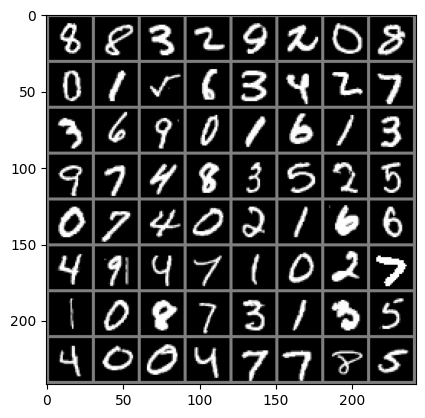

In [224]:
# Let's show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [225]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [226]:
class LeNet5(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# Layer 1 is a convolutional layer with 6 filters and a 5x5 size
		# MNIST contains grey scale images, so we only have 1 input channels
		self.conv1 = nn.Conv2d(
			in_channels=1, 
			out_channels=6,
			kernel_size=(5, 5),
			padding=2,  # Add a padding of 2 0 pixles around the border (MNIST images are 28x28 and model input is 32x32)
		)
		# Layer 2 is a 2x2 average pooling, which takes avg over four inputs (stride=2)
		# (experiment with max pooling) and is also passed through a sigmoid
		self.avg_pool1 = nn.AvgPool2d(
			kernel_size=(2, 2),
			stride=(2, 2),
		)
		self.sig1 = nn.Sigmoid()
		
		# Layer 3 sees us connecting different parts of the feature maps from layer 2
		# To implement this I initialise 15 different convolutions with each having an output dimension of 1
		# I used name convetion conv2_[num in]_[C3 feature map number]
		# 3 inputs
		self.conv2_3_0 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_1 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_3 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_4 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		self.conv2_3_5 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(5,5))
		# 4 inputs
		self.conv2_4_6 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_7 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_8 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_9 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_10 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_11 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_12 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_13 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		self.conv2_4_14 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=(5,5))
		# 6 inputs
		self.conv2_6_15 = nn.Conv2d(in_channels=6, out_channels=1, kernel_size=(5,5))
		
		# Layer 4 is another subsampling layer with 2x2 average pooling
		self.avg_pool2 = nn.AvgPool2d(
			kernel_size=(2, 2),
			stride=(2, 2),
		)
		
		# Layer 5 is a convolutionallayer with 120 feature maps and a 5x5 convoltuion
		# This results in a height and width of 1 for each feature map
		self.conv3 = nn.Conv2d(
			in_channels=16,
			out_channels=120,
			kernel_size=(5, 5)
		)
		
		# Layer 6 if a fully connected (Linear layer) which computers y = xA + b (the dot product between input vector and the weight vector
		# and adds a bias) 
		# It is also passed through an activation (squashing) function in this case we use tanh
		self.linear1 = nn.Linear(120, 84)
		self.tanh1 = nn.Tanh()
		
		# Output layer is supposed to use Euclidean Radial Basic Function units but I use softmax (TODO: implement RVF)
		# I first pass F6 through a fully connected layer to get 10 length vector
		self.linear2 = nn.Linear(84, 10)
		#self.softmax1 = nn.Softmax()
		
	def forward(self, x):
		# C1 - 5x5 convolution - output is 6, 28x28 filters
		x = self.conv1(x)
		#print(f'Shape after C1: {x.shape}')
		# S2 - 2x2 avg pooling, which is passed through a sigmoid - output is 6 14x14 filters
		x = self.avg_pool1(x)
		x = self.sig1(x)
		#print(f'Shape after S2: {x.shape}')
		# C3 - 5x5 convolution but we must engineer the connections from the previous layer
		# feature map 0-5 in C3 are connected to 3 contiguous feature maps from S2 (e.g. 0-2, 1-3, 2-4 etc.)
		# feature map 6 - 11 are connected in the same way but to 4 contiguous feature maps
		# feature map 12 - 14 are the same but discontiguous 4 feature maps
		# feature map 15 is all 6 maps from S2
		map_ranges = [
			# Length 3 maps 0-5
			(0, 1, 2), (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 0), (5, 0, 1),
			# Length 4 maps 6-11
			(0, 1, 2, 3), (1, 2, 3, 4), (2, 3, 4, 5), (3, 4, 5, 0), (4, 5, 0, 1), (5, 0, 1, 2),
			# Length 4 maps discontiguous 12-14
			(0, 1, 3, 4), (1, 2, 4, 5), (0, 2, 3, 5),
			# All maps 15
			(0, 1, 2, 3, 4, 5),
		]
		# We assume tensor dimensions are (batch_size, channels, width, length) and apply each map to the specific conv layer defined in init
		c3_maps = []
		c3_maps.append(self.conv2_3_0(x[:, map_ranges[0], :, :]))
		c3_maps.append(self.conv2_3_1(x[:, map_ranges[1], :, :]))
		c3_maps.append(self.conv2_3_2(x[:, map_ranges[2], :, :]))
		c3_maps.append(self.conv2_3_3(x[:, map_ranges[3], :, :]))
		c3_maps.append(self.conv2_3_4(x[:, map_ranges[4], :, :]))
		c3_maps.append(self.conv2_3_5(x[:, map_ranges[5], :, :]))
		
		c3_maps.append(self.conv2_4_6(x[:, map_ranges[6], :, :]))
		c3_maps.append(self.conv2_4_7(x[:, map_ranges[7], :, :]))
		c3_maps.append(self.conv2_4_8(x[:, map_ranges[8], :, :]))
		c3_maps.append(self.conv2_4_9(x[:, map_ranges[9], :, :]))
		c3_maps.append(self.conv2_4_10(x[:, map_ranges[10], :, :]))
		c3_maps.append(self.conv2_4_11(x[:, map_ranges[11], :, :]))
		c3_maps.append(self.conv2_4_12(x[:, map_ranges[12], :, :]))
		c3_maps.append(self.conv2_4_13(x[:, map_ranges[13], :, :]))
		c3_maps.append(self.conv2_4_14(x[:, map_ranges[14], :, :]))
		
		c3_maps.append(self.conv2_6_15(x[:, map_ranges[15], :, :]))
			
		# To complete C3 we concatenate all 16 convolutional layers which produces a tensor of 16 layers together
		x = torch.cat(c3_maps, dim=1)
		#print(f'Shape after C3: {x.shape}')
		
		# S4 is another subsampling layer (not sure if I need to add sigmoid here?)
		x = self.avg_pool2(x)
		#print(f'Shape after S4: {x.shape}')
		
		# C5 is a 5x5 convolution with 120 filters, this flattens the input from S4 as we end up with a 1x1 2-d matrix
		x = self.conv3(x)
		#print(f'Shape after C5: {x.shape}')
	
		# Before passing to the fully connected layer we must flatten the tensor as nn.Linear expects a vecotr (1d input)
		x = torch.flatten(x, start_dim=1)
		# F6 is a fully connected layer which is passed through a tanh
		x = self.linear1(x)
		x = self.tanh1(x)
		#print(f'Shape after F6: {x.shape}')
		
		# We first create another fully connected layer and then pass the output through a softmax.
		# The softmax converts the logits to probabilites (sum to 1)
		# The output layer uses softmax to output 10 probabilites for each class (0-9 digits)
		x = self.linear2(x)
		# x = self.softmax1(x) if using cross entropy loss don't apply softmax
		#print(f'Shape at output: {x.shape}')
		
		return x

net = LeNet5()
net.to(mps_device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg_pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (sig1): Sigmoid()
  (conv2_3_0): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_3_1): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_3_2): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_3_3): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_3_4): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_3_5): Conv2d(3, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_6): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_7): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_8): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_9): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_10): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_11): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2_4_12): Conv2d(4, 1, kernel_size=(5, 5), stride=(1, 1))
  (c

In [227]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [241]:
# Defining the optimizer and loss function
# criterion = nn.MSELoss()
# Use Cross Entropy Loss instead
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [242]:
# Training the model
for epoch in range(20):
	running_loss = 0.0
	
	for i, data in enumerate(train_dataloader, 0):
		inputs, labels = data
		inputs, labels = inputs.to(mps_device), labels.to(mps_device)
		#labels = labels.to(torch.float32)
		optimizer.zero_grad()
		
		outputs = net(inputs)
		loss = criterion(outputs, labels)
		#print(loss.dtype, labels.dtype)
		loss.backward()
		optimizer.step()
		
		running_loss += loss.item()
	
	# Move this print statement outside the inner loop
	print(f'Epoch [{epoch + 1}] loss: {running_loss / len(train_dataloader):.3f}')
	running_loss = 0.0

print('Finished Training')

Epoch [1] loss: 0.214
Epoch [2] loss: 0.178
Epoch [3] loss: 0.155
Epoch [4] loss: 0.140
Epoch [5] loss: 0.126
Epoch [6] loss: 0.117
Epoch [7] loss: 0.109
Epoch [8] loss: 0.101
Epoch [9] loss: 0.096
Epoch [10] loss: 0.090
Epoch [11] loss: 0.084
Epoch [12] loss: 0.080
Epoch [13] loss: 0.077
Epoch [14] loss: 0.073
Epoch [15] loss: 0.069
Epoch [16] loss: 0.066
Epoch [17] loss: 0.064
Epoch [18] loss: 0.061
Epoch [19] loss: 0.059
Epoch [20] loss: 0.056
Finished Training


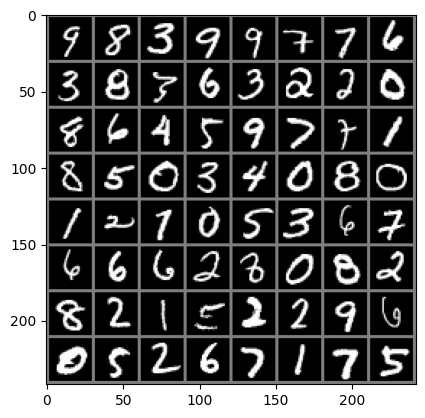

In [243]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))

# Push images to mps gpu
images, labels = images.to(mps_device), labels.to(mps_device)

In [244]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
predicted

tensor([9, 8, 3, 9, 9, 7, 7, 6, 3, 8, 7, 6, 3, 2, 2, 0, 8, 6, 4, 5, 9, 7, 8, 1,
        8, 5, 0, 3, 4, 0, 8, 0, 1, 2, 7, 0, 5, 3, 6, 7, 6, 6, 6, 2, 3, 0, 8, 2,
        8, 2, 1, 5, 2, 2, 9, 6, 0, 5, 2, 6, 7, 1, 7, 5], device='mps:0')

In [245]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
	for data in test_dataloader:
		images, labels = data
		# Push images to mps gpu
		images, labels = images.to(mps_device), labels.to(mps_device)
		
		# calculate outputs by running images through the network
		outputs = net(images)
		# the class with the highest energy is what we choose as prediction
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %


# Lets visualise what the model is actually doing


In [254]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

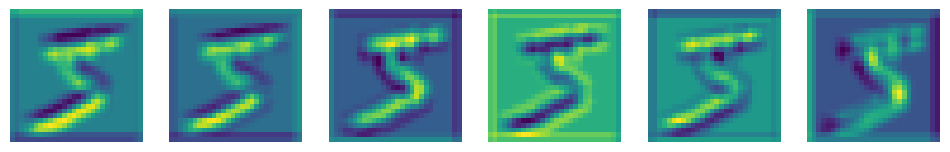

In [269]:
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

# Define a function to attach a hook
activation_maps = {}
def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach()
    return hook

# Assuming 'net' is your model instance, and you want to visualize the output of 'conv1'
net.conv1.register_forward_hook(get_activation('conv1'))
net.avg_pool1.register_forward_hook(get_activation('avg_pool1'))
net.avg_pool2.register_forward_hook(get_activation('avg_pool2'))
net.conv3.register_forward_hook(get_activation('conv3'))

# Process an image through your network
# Make sure the input tensor is of the correct shape, e.g., [batch_size, channels, height, width]
# and moved to the same device as your model

input_tensor = mnist_train[0][0]  # input tensor
# We need to add a dimension to the tensor (batch size dim)
input_tensor = input_tensor[None, :, :, :]
input_tensor = input_tensor.to(mps_device)
output = net(input_tensor)

# Plotting the feature maps
feature_maps = activation_maps['conv1'].squeeze()  # Remove batch dimension for plotting
fig, axes = plt.subplots(1, feature_maps.size(0), figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(feature_maps[i].cpu().numpy())
    ax.axis('off')
plt.show()

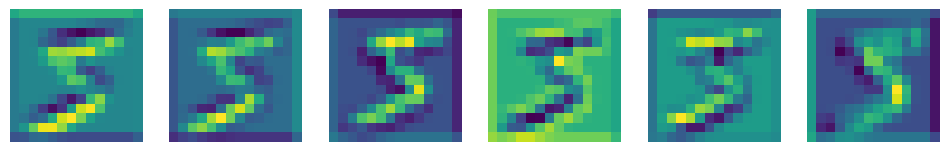

In [270]:
# Plotting the feature maps
feature_maps = activation_maps['avg_pool1'].squeeze()  # Remove batch dimension for plotting
fig, axes = plt.subplots(1, feature_maps.size(0), figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(feature_maps[i].cpu().numpy())
    ax.axis('off')
plt.show()

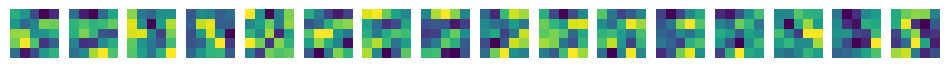

In [271]:
# Plotting the feature maps
feature_maps = activation_maps['avg_pool2'].squeeze()  # Remove batch dimension for plotting
fig, axes = plt.subplots(1, feature_maps.size(0), figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(feature_maps[i].cpu().numpy())
    ax.axis('off')
plt.show()

In [117]:
# Create a dummy input tensor with the expected input size
# Assuming the input size is (channels, height, width)
dummy_input = torch.randn(3, 32, 32)  # For example, a single 32x32 RGB image

# Pass the dummy input through the network
output = net(dummy_input)

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[1, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [87]:
dummy_C5 = torch.rand(120, 1, 1)
flat = torch.flatten(dummy_C5, start_dim=0)
flat.shape

torch.Size([120])